In [1]:
import ahocorasick
from bs4 import BeautifulSoup
import boto3
import config as cfg
import datetime 
import io
import neuralcoref
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import spacy
import time
import tldextract
from urllib.parse import urlparse
import yaml

In [2]:
%run "../libraries/aws_utils.ipynb"

In [3]:
%run "../libraries/general_utils.ipynb"

In [4]:
with open('../data_engineering/config.yml', 'r') as file:
   config_files = yaml.safe_load(file)

## Load data

In [5]:
nlp = spacy.load("en_core_web_sm")
neuralcoref.add_to_pipe(nlp)

In [6]:
s3_reader = boto3.resource('s3',
                    region_name='us-east-1',
                    aws_access_key_id=cfg.aws_reader['accessCode'],
                    aws_secret_access_key=cfg.aws_reader['secretCode'])

In [7]:
text = read_parquet_file(s3_reader, 
                                  config_files['INTEREDIARY_OUTPUT_BUCKET'], 
                      config_files['SCRAPED_ARTICLE_TEXT_AND_REFERENCE_TEXT'],
                                          )
test_primary_key(text, ['article_id', 'file_name'])

In [8]:
article_to_afd_join_key = read_parquet_file(s3_reader, 
                                  config_files['INTEREDIARY_OUTPUT_BUCKET'], 
                      config_files['JOINED_ARTICLE_SCRAPE_DATES_AND_AFD_NAMES'],
                                          )
test_primary_key(article_to_afd_join_key, ['article_id', 'file_name'])

In [9]:
original_rows = text.shape[0]
text = text.merge(article_to_afd_join_key[['article_id','file_name','entity']],
                on = ['article_id', 'file_name'],
                how="left")
assert original_rows == text.shape[0]

In [10]:
names = read_parquet_file(s3_reader, 
                                  config_files['INTEREDIARY_OUTPUT_BUCKET'], 
                      config_files['INFERRED_GENDER'],
                  )
test_primary_key(names, ['entity', 'file_name'])

In [11]:
names[0:3]

,entity,found_person,num_entities,is_multiple_entity_types,file_name,discussion,afd_result,first_name,last_name,inferred_gender
0,Margaret Louise Skourlis,True,1,False,daily_afd_log/2023-01-01/2022_December_21.txt,"<div class=""boilerplate afd vfd xfd-closed arc...",delete,Margaret,Skourlis,female
1,Michael D. Mehta,True,1,False,daily_afd_log/2023-01-01/2022_December_21.txt,"<div class=""boilerplate afd vfd xfd-closed arc...",delete,Michael,Mehta,male
2,Sangsadia Nirbachan 1991,True,1,False,daily_afd_log/2023-01-01/2022_December_21.txt,"<div class=""boilerplate afd vfd xfd-closed arc...",merge,Sangsadia,Nirbachan,unknown


In [12]:
original_rows = text.shape[0]
text = text.merge(names[['entity','file_name','found_person','num_entities','afd_result','first_name','last_name','inferred_gender']],
                on = ['entity', 'file_name'],
                how="left")
assert original_rows == text.shape[0]

In [13]:
text[0:3]

,article_id,file_name,scraped_path,wiki_article,articles_text,references_text,has_references,entity,found_person,num_entities,afd_result,first_name,last_name,inferred_gender
0,A.S.D._Villabiagio,daily_afd_log/2023-01-03/2022_December_23.txt,individual_afd_page_html/2023-01-01/A.S.D._Vil...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","<!DOCTYPE html>\n<html class=""client-nojs"" lan...",None,False,A.S.D. Villabiagio,True,1,keep,A.S.D.,Villabiagio,unknown
1,Aaron_Kemmer,daily_afd_log/2023-01-19/2023_January_8.txt,individual_afd_page_html/2023-01-01/Aaron_Kemm...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","<!DOCTYPE html>\n<html class=""client-nojs"" lan...","<span class=""mw-editsection""><span class=""mw-e...",True,Aaron Kemmer,True,1,delete,Aaron,Kemmer,male
2,Abbas_Sajwani,daily_afd_log/2023-01-07/2022_December_27.txt,individual_afd_page_html/2023-01-01/Abbas_Sajw...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","<!DOCTYPE html>\n<html class=""client-nojs"" lan...","<span class=""mw-editsection""><span class=""mw-e...",True,Abbas Sajwani,True,1,delete,Abbas,Sajwani,male


In [14]:
text['articles_text'] = text['articles_text'].apply(lambda x: x.split("</head>")[1]) # remove header

## Extract pronouns on wiki articles

In [16]:
text['articles_text_wo_tags']  = text['articles_text'].apply(lambda x: BeautifulSoup(x, 'html.parser').text)
text['articles_text_wo_tags'] = text['articles_text_wo_tags'].apply(lambda x: x.replace("\n"," "))

In [17]:
text[0:3]

,article_id,file_name,scraped_path,wiki_article,articles_text,references_text,has_references,entity,found_person,num_entities,afd_result,first_name,last_name,inferred_gender,articles_text_wo_tags
0,A.S.D._Villabiagio,daily_afd_log/2023-01-03/2022_December_23.txt,individual_afd_page_html/2023-01-01/A.S.D._Vil...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","\n<body class=""skin-vector-legacy mediawiki lt...",None,False,A.S.D. Villabiagio,True,1,keep,A.S.D.,Villabiagio,unknown,"A.S.D. Villabiagio From Wikipedia, t..."
1,Aaron_Kemmer,daily_afd_log/2023-01-19/2023_January_8.txt,individual_afd_page_html/2023-01-01/Aaron_Kemm...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","\n<body class=""skin-vector-legacy mediawiki lt...","<span class=""mw-editsection""><span class=""mw-e...",True,Aaron Kemmer,True,1,delete,Aaron,Kemmer,male,"Aaron Kemmer From Wikipedia, the fre..."
2,Abbas_Sajwani,daily_afd_log/2023-01-07/2022_December_27.txt,individual_afd_page_html/2023-01-01/Abbas_Sajw...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","\n<body class=""skin-vector-legacy mediawiki lt...","<span class=""mw-editsection""><span class=""mw-e...",True,Abbas Sajwani,True,1,delete,Abbas,Sajwani,male,"Abbas Sajwani From Wikipedia, the fr..."


In [18]:
def parse_document(document):
    """
    Parses the given document using a natural language processing (NLP) model and extracts the tokens.

    Args:
        document (str): The document to be parsed.

    Returns:
        list: A list of tokens extracted from the document.

    """
    doc = nlp(document)
    tokens = [token.text for token in doc]
    return tokens

text['article_tokens'] = text['articles_text_wo_tags'].apply(lambda x: parse_document(x))

In [19]:
text['num_tokens'] = text['article_tokens'].apply(lambda x: len(x))

In [20]:
def count_token_matches(token_list, tokens_to_count):
    """
    Counts the number of matching tokens between a given list of tokens and a list of tokens to count.

    Args:
        token_list (list): A list of tokens to search within.
        tokens_to_count (list): A list of tokens to count occurrences of.

    Returns:
        int: The count of matching tokens between the two lists.
    """
    token_list = [x.lower().strip() for x in token_list]
    matching_items = [item for item in token_list if item in tokens_to_count]
    count = len(matching_items)
    return count

male_pronouns = ['he', 'him', 'his']
text['num_male_tokens'] = text['article_tokens'].apply(lambda x: count_token_matches(x, male_pronouns))

female_pronouns = ['she', 'her', 'hers', ]
text['num_female_tokens'] = text['article_tokens'].apply(lambda x: count_token_matches(x, female_pronouns))

non_binary_pronouns = ['they', 'them', 'their', 'theirs']
text['num_non_binary_tokens'] = text['article_tokens'].apply(lambda x: count_token_matches(x, non_binary_pronouns))

neo_pronouns = ['xe', 'xem', 'xyr', 'ze', 'hir', 'hirs', 'ey', 'em', 'eir']
text['num_neo_tokens'] = text['article_tokens'].apply(lambda x: count_token_matches(x, neo_pronouns))

In [21]:
text['sum_pronouns'] = text[['num_male_tokens', 'num_female_tokens', 'num_non_binary_tokens', 'num_neo_tokens']].sum(axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sum_pronouns', ylabel='Density'>

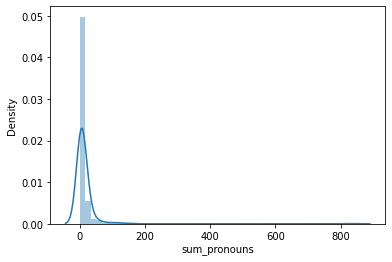

In [22]:
sns.distplot(text['sum_pronouns'])

## For rows where we found pronouns, evaluate the pronoun coreferences the article's subject

In [23]:
def extract_coreference_pronouns(wiki_text, full_name, first_name, sum_pronouns):
    """
    Extracts coreferenced pronouns from the given Wikipedia text that refer to the specified full name or first name.

    Args:
        wiki_text (str): The Wikipedia text containing potential coreferenced pronouns.
        full_name (str): The full name to check for coreference.
        first_name (str): The first name to check for coreference.
        sum_pronouns (int): The total number of pronouns.

    Returns:
        list: A list of lowercased pronouns coreferenced to the specified full name or first name.
    """
     
    pronouns_coreferenced_to_name = []
    if sum_pronouns > 0:
        pronouns = male_pronouns + female_pronouns + non_binary_pronouns + neo_pronouns
        

        wiki_text_without_parenthesis = re.sub(r'\([^)]*\)', '', wiki_text) # also remove text in parenthesis
        wiki_text = wiki_text + wiki_text_without_parenthesis
        doc = nlp(wiki_text) 
        for token in doc:
            if token.text.lower() in pronouns:
                try:
                    antecedent = token._.coref_clusters[0].main.text.strip() # All the clusters of corefering mentions in the doc
                    if antecedent in (full_name, first_name):
                        pronouns_coreferenced_to_name.append(token.text.lower())
                except Exception as e:
                    print("An error occurred while processing the document:", e)
    return pronouns_coreferenced_to_name

In [24]:
start_time = time.time()
text['coreference_pronouns'] = text[['articles_text_wo_tags', 'entity', 'first_name', 'sum_pronouns']].apply(lambda x: 
                                                                                                             extract_coreference_pronouns(x[0], x[1], x[2], x[3]), axis=1)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: li

An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: li

An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: li

An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: li

An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: li

An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: li

An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: list index out of range
An error occurred while processing the document: li

In [25]:
male_pronouns = ['he', 'him', 'his']
text['num_male_coreference_tokens'] = text['coreference_pronouns'].apply(lambda x: count_token_matches(x, male_pronouns))

female_pronouns = ['she', 'her', 'hers', ]
text['num_female_coreference_tokens'] = text['coreference_pronouns'].apply(lambda x: count_token_matches(x, female_pronouns))

non_binary_pronouns = ['they', 'them', 'their', 'theirs']
text['num_non_binary_coreference_tokens'] = text['coreference_pronouns'].apply(lambda x: count_token_matches(x, non_binary_pronouns))

neo_pronouns = ['xe', 'xem', 'xyr', 'ze', 'hir', 'hirs', 'ey', 'em', 'eir']
text['num_neo_coreference_tokens'] = text['coreference_pronouns'].apply(lambda x: count_token_matches(x, neo_pronouns))

In [26]:
coref_tokens_columns = ['num_male_coreference_tokens', 'num_female_coreference_tokens',
                             'num_non_binary_coreference_tokens', 'num_neo_coreference_tokens']

text['sum_coreference_pronouns'] = text[coref_tokens_columns].sum(axis=1)
text[coref_tokens_columns] = text[coref_tokens_columns].fillna(0)

In [27]:
def calculate_percentage(df, numerator_col, denominator_col, output_col):
    df[output_col] = df[numerator_col] / df[denominator_col]
    return df
    
gender = 'male'
text = calculate_percentage(text, f'num_{gender}_coreference_tokens', 'sum_coreference_pronouns', f'pct_{gender}_coreference_pronouns')
gender = 'female'
text = calculate_percentage(text, f'num_{gender}_coreference_tokens', 'sum_coreference_pronouns', f'pct_{gender}_coreference_pronouns')
gender = 'non_binary'
text = calculate_percentage(text, f'num_{gender}_coreference_tokens', 'sum_coreference_pronouns', f'pct_{gender}_coreference_pronouns')
gender = 'neo'
text = calculate_percentage(text, f'num_{gender}_coreference_tokens', 'sum_coreference_pronouns', f'pct_{gender}_coreference_pronouns')

In [28]:
text[0:5]

,article_id,file_name,scraped_path,wiki_article,articles_text,references_text,has_references,entity,found_person,num_entities,...,coreference_pronouns,num_male_coreference_tokens,num_female_coreference_tokens,num_non_binary_coreference_tokens,num_neo_coreference_tokens,sum_coreference_pronouns,pct_male_coreference_pronouns,pct_female_coreference_pronouns,pct_non_binary_coreference_pronouns,pct_neo_coreference_pronouns
0,A.S.D._Villabiagio,daily_afd_log/2023-01-03/2022_December_23.txt,individual_afd_page_html/2023-01-01/A.S.D._Vil...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","\n<body class=""skin-vector-legacy mediawiki lt...",None,False,A.S.D. Villabiagio,True,1,...,[],0,0,0,0,0,NaN,NaN,NaN,NaN
1,Aaron_Kemmer,daily_afd_log/2023-01-19/2023_January_8.txt,individual_afd_page_html/2023-01-01/Aaron_Kemm...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","\n<body class=""skin-vector-legacy mediawiki lt...","<span class=""mw-editsection""><span class=""mw-e...",True,Aaron Kemmer,True,1,...,"[he, his, his, his, he, his, he, his, his]",9,0,0,0,9,1.0,0.0,0.0,0.0
2,Abbas_Sajwani,daily_afd_log/2023-01-07/2022_December_27.txt,individual_afd_page_html/2023-01-01/Abbas_Sajw...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","\n<body class=""skin-vector-legacy mediawiki lt...","<span class=""mw-editsection""><span class=""mw-e...",True,Abbas Sajwani,True,1,...,"[he, he]",2,0,0,0,2,1.0,0.0,0.0,0.0
3,Abby_Chin,daily_afd_log/2023-02-21/2023_February_10.txt,individual_afd_page_html/2023-02-21/Abby_Chin.txt,"<!DOCTYPE html>\n<html class=""client-nojs vect...","\n<body class=""skin-vector skin-vector-search-...","<span class=""mw-editsection""><span class=""mw-e...",True,Abby Chin,True,1,...,"[she, she, she]",0,3,0,0,3,0.0,1.0,0.0,0.0
4,Abdallah_Abu_Sheikh,daily_afd_log/2023-01-21/2023_January_11.txt,individual_afd_page_html/2023-01-01/Abdallah_A...,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...","\n<body class=""skin-vector-legacy mediawiki lt...","<span class=""mw-editsection""><span class=""mw-e...",True,Abdallah Abu Sheikh,True,1,...,[],0,0,0,0,0,NaN,NaN,NaN,NaN


## Write output

In [29]:
test_primary_key(text, ['article_id', 'file_name'])

In [30]:
# drop text-heavy columns stored in other output files already
drop = ['wiki_article', 'articles_text', 'references_text', 'has_references']

In [31]:
s3_writer = boto3.client('s3',
                    region_name='us-east-1',
                    aws_access_key_id=cfg.aws_writer['accessCode'],
                    aws_secret_access_key=cfg.aws_writer['secretCode'])

In [32]:
out_buffer = io.BytesIO()
text.drop(drop, axis=1).to_parquet(out_buffer, index=False)
s3_writer.put_object( Bucket=config_files['INTEREDIARY_OUTPUT_BUCKET'], 
                     Key=config_files['EXTRACTED_PRONOUNS'], 
                     Body=out_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '4YT2QG7M8TZ5N0GG',
  'HostId': 'u4ehtFwRpQiBemvCZXb8uHTNwHD4fPPmS5aQwuCsFbkj/oxRzpF2Fj23C8H2YuTOuf2fl8J9Erg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'u4ehtFwRpQiBemvCZXb8uHTNwHD4fPPmS5aQwuCsFbkj/oxRzpF2Fj23C8H2YuTOuf2fl8J9Erg=',
   'x-amz-request-id': '4YT2QG7M8TZ5N0GG',
   'date': 'Sun, 11 Jun 2023 17:16:26 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"36bb2f1ebd9924d5d0cdeeba512e1e49"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"36bb2f1ebd9924d5d0cdeeba512e1e49"',
 'ServerSideEncryption': 'AES256'}